In [35]:
import numpy as np
from sklearn.datasets import make_moons
import math
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib import cm
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

In [36]:
"""
N_SAMPLES = 1000
X_data, y_data_t = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=50)
y_data = y_data_t.reshape(N_SAMPLES,1)
m = int(X_data.shape[0])
m_tr = int(math.ceil((90/100)*m))
m_cv = int(math.ceil((5/100)*m))
m_te = m - (m_tr + m_cv)
X_tr = np.zeros((m_tr,X_data.shape[1]))
y_tr_t = np.zeros((m_tr,1))
X_cv = np.zeros((m_cv,X_data.shape[1]))
y_cv_t = np.zeros((m_cv,1))
X_te = np.zeros((m_te,X_data.shape[1]))
y_te_t = np.zeros((m_te,1))
perm = np.random.permutation(m)
p = perm.reshape(m,1)
for i in range(0,m_tr):
  X_tr[i] = X_data[p[i]]
  y_tr_t[i] = y_data[p[i]]
for i in range(0,m_cv):
  X_cv[i] = X_data[p[i+m_tr]]
  y_cv_t[i] = y_data[p[i+m_tr]]
for i in range(0,m_te):
  X_te[i] = X_data[p[i+m_tr+m_cv]]
  y_te_t[i] = y_data[p[i+m_tr+m_cv]]
y_tr = y_tr_t.T
y_cv = y_cv_t.T
y_te = y_te_t.T
"""

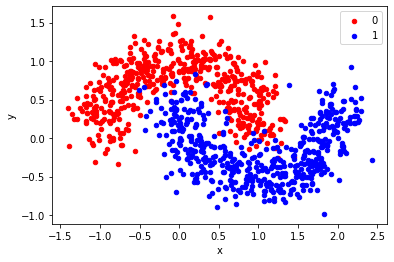

In [37]:
"""
df = DataFrame(dict(x=X_data[:,0], y=X_data[:,1], label=y_data_t))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()
"""

In [55]:

(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

# Preparing the data
Y_tr_resh = Y_train_orig.reshape(60000, 1)
Y_te_resh = Y_test_orig.reshape(10000, 1)
Y_tr_T = to_categorical(Y_tr_resh, num_classes=10)
Y_te_T = to_categorical(Y_te_resh, num_classes=10)
y_tr = Y_tr_T.T
y_te = Y_te_T.T


# Flattening of inputs
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Preprocessing of Inputs
X_tr = X_train_flatten.T / 255.
X_te = X_test_flatten.T / 255.
num_classes = y_tr.shape[0]
m_tr = X_tr.shape[0]
m_te = X_te.shape[0]


In [39]:
class Activations:
  """
      Contains the activation functions and their gradients along with the variables 
      necessary for initializing the weights of the neural network.
      SubClasses:
        ActivationsForward
        ActivationsBackward
  """
  @staticmethod
  def relu(x):
    return np.maximum(0,x)
    
  @staticmethod
  def tanh(x):
    return np.tanh(x)
    
  @staticmethod
  def sigmoid(x):
    calc = 1 / (1 + np.exp(-x))
    return calc

  @staticmethod
  def softmax(x):
    soft = np.exp(x)/np.sum(np.exp(x),axis=0)
    return soft

  @staticmethod
  def relu_backward(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

  @staticmethod
  def tanh_backward(x):
    return (1 - np.square(Activations.tanh(x)))

  @staticmethod
  def sigmoid_backward(x):
    sig = Activations.sigmoid(x)
    return sig*(1-sig)
  
  @staticmethod
  def softmax_backward(x):
    calc = Activations.softmax(x)
    return calc*(1-calc)

In [40]:
class CostFunction:
  @staticmethod
  def binary_cross_entropy(y, A):
    cost = (-1/y.shape[1])*(np.sum(np.sum((y*np.log(A)) + ((1-y)*(np.log(1-A))))))
    grad = (-1/y.shape[1])*((y/A)-((1-y)/(1-A)))
    return cost,grad

  @staticmethod
  def cross_entropy(y,A):
    cost = (-1/y.shape[1])*(np.sum(np.sum((y*np.log(A)))))
    grad = (-1/y.shape[1])*((y/A))
    return cost,grad

In [88]:
class Helpers:
  """
      Contains the helper functions for calculating Cost Function, predicting and
      accuracy of the network
      Methods:
        CostFunction
        Predictions
        Accuracy
  """

  @staticmethod
  def predict(A,threshold=0.5):
    predictions = np.zeros((A.shape))
    for g in range(0,A.shape[1]):
      if A[:,g] >= threshold:
        predictions[:,g] = 1
    return predictions
  
  @staticmethod
  def predict_multi(A):
    predictions_multi = np.zeros(A.shape)
    for v in range(0,A.shape[1]):
      temp = max(A[:,v])
      for w in range(0,A.shape[0]):
        if A[w,v] == temp:
          predictions_multi[w,v] = 1
        else:
          predictions_multi[w,v] = 0
    return predictions_multi

  @staticmethod
  def evaluate(y, preds,A=None):
    accuracy = float(np.mean(preds==y,axis=1)*100)
    return accuracy

  @staticmethod
  def evaluate_multi(y,preds,A):
    predictions_multi = Helpers.predict_multi(A)
    ones_array = np.ones(preds.shape)
    temp1 = preds==ones_array
    ind = []
    for gee in range(0,temp1.shape[1]):
      for jee in range(0,temp1.shape[0]):
        if temp1[jee,gee] == True:
          ind.append(jee)
    ind_arr = np.array(ind)
    y_list = []
    for gee in range(0,y.shape[1]):
      for jee in range(0,y.shape[0]):
        if y[jee,gee] == 1:
          y_list.append(jee)
    y_arr = np.array(y_list)
    accuracy = float(np.mean(ind_arr == y_arr.T))*100
    return accuracy
  
  @staticmethod
  def prec_rec(A,y):
    epsilon = 1e-5
    tp = 0
    fp = 0
    fn = 0
    for i in range(0,y.shape[1]):
      if ((A[0,i]==1)and(y[0,i]==1)):
        tp = tp+1
      if ((A[0,i]==1)and(y[0,i]==0)):
        fp = fp+1
      if (A[0,i]==0)and(y[0,i]==1):
        fn = fn+1
    prec = tp/(tp+fp+epsilon)
    rec = tp/(tp+fn+epsilon)
    f1 = (2*prec*rec)/(prec+rec+epsilon)
    return prec,rec,f1

  @staticmethod
  def prec_rec_multi(A,y):
    epsilon = 1e-5
    tp_multi = {}
    fp_multi = {}
    fn_multi = {}
    prec_multi = {}
    rec_multi = {}
    f1_multi = {}
    for r in range(0,num_classes):
      tp_multi["class" + str(r)] = 0
      fp_multi["class" + str(r)] = 0
      fn_multi["class" + str(r)] = 0
    for c in range(0,y.shape[1]):
      for g in range(0,y.shape[0]):
        if ((A[g,c]==1) and (y[g,c]==1)):
          tp_multi["class" + str(g)] = tp_multi["class" + str(g)] + 1
        if ((A[g,c]==1) and (y[g,c]==0)):
          fp_multi["class" + str(g)] = fp_multi["class" + str(g)] + 1
        if ((A[g,c]==0) and (y[g,c]==1)):
          fn_multi["class" + str(g)] = fn_multi["class" + str(g)] + 1
    for n in range(0,num_classes):
      prec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fp_multi["class" + str(n)] + epsilon)
      rec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fn_multi["class" + str(n)] + epsilon)
      f1_multi["class" + str(n)] = (2*prec_multi["class" + str(n)]*rec_multi["class" + str(n)])/(prec_multi["class" + str(n)] + rec_multi["class" + str(n)] + epsilon)
    return prec_multi,rec_multi,f1_multi

In [87]:
y = y_tr
y_list = []
for gee in range(0,y.shape[1]):
  for jee in range(0,y.shape[0]):
    if y[jee,gee] == 1:
      y_list.append(jee)
y_arr = np.array(y_list)
print(y_arr[0:5])
print(y[:,0:5])

[5 0 4 1 9]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [60]:
class Dense:
  """
      This layer is used for implemetation of Fully Connected Neural Networks
      Methods:
        Parameters Initialization
        Forward Propagation
        Backward Propagation
  """
  def __init__(self,num_inputs,num_outputs,activation_fn,weights=None,bias=None,dZ=None,dW=None,db=None,dA=None):
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.activation_fn = activation_fn
    self.dZ,self.dW,self.db,self.dA = dZ,dW,db,dA
    self.weights = weights
    self.bias = bias
    self.activ_dict = {"relu":[Activations.relu,Activations.relu_backward,2],
                       "tanh":[Activations.tanh,Activations.tanh_backward,1],
                       "sigmoid":[Activations.sigmoid,Activations.sigmoid_backward,1],
                       "softmax":[Activations.softmax,Activations.softmax_backward,1]}

  def initialize_params(self):
    self.weights = np.random.randn(self.num_outputs,self.num_inputs)*(np.sqrt(self.activ_dict[self.activation_fn][2]/self.num_inputs))
    self.bias = np.random.randn(self.num_outputs, 1)*0.01
    return self.weights,self.bias

  def get_params(self):
    return self.weights, self.bias
    
  def forw_prop(self,A_prev):
    self.outputs = np.dot(self.weights,A_prev) + self.bias
    self.activations = self.activ_dict[self.activation_fn][0](self.outputs)
    return self.outputs,self.activations

  def back_prop(self,dA_prev,A_prev):
    self.dZ = dA_prev*self.activ_dict[self.activation_fn][1](self.outputs)
    self.dW = np.dot(self.dZ,A_prev.T)
    self.db = np.sum(self.dZ,axis=1,keepdims = True)
    self.dA = np.dot(self.weights.T,self.dZ)
    return self.dZ,self.dW,self.db,self.dA

In [61]:
class Optimizers:
  """
      Contains the optimizers for the Neural Networks and for updating of parameters
      SubClasses:
        GradientDescent
        Adam
        Momentum
        StochasticGradientDescent
  """
  @staticmethod
  def gradient_descent(alpha,layers_arr,V_dict,S_dict,t):
    for layers in layers_arr:
      layers.weights -= (alpha*layers.dW)
      layers.bias -= (alpha*layers.db)

  @staticmethod
  def gd_mom(alpha,layers_arr,V_dict,S_dict,t):
    beta1 = 0.9
    for h in range(1,len(layers_arr)+1):
      V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*layers_arr[h-1].dW)
      V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*layers_arr[h-1].db)
    for g in range(1,len(layers_arr)+1):
      layers_arr[g-1].weights -= (alpha*V_dict["Vdw" + str(g)])
      layers_arr[g-1].bias -= (alpha*V_dict["Vdb" + str(g)])
  
  @staticmethod
  def rms_prop(alpha,layers_arr,V_dict,S_dict,t):
    beta2 = 0.999
    epsilon = 1e-8
    for h in range(1,len(layers_arr)+1):
      S_dict["Sdw" + str(h)] = (beta2*S_dict["Sdw" + str(h)]) + ((1-beta2)*np.square(layers_arr[h-1].dW))
      S_dict["Sdb" + str(h)] = (beta2*S_dict["Sdb" + str(h)]) + ((1-beta2)*np.square(layers_arr[h-1].db))
    for g in range(1,len(layers_arr)+1):
      layers_arr[g-1].weights -= ((alpha*layers_arr[g-1].dW)/(np.sqrt(S_dict["Sdw" + str(g)]) + epsilon))
      layers_arr[g-1].bias -= ((alpha*layers_arr[g-1].db)/(np.sqrt(S_dict["Sdb" + str(g)]) + epsilon))

  @staticmethod
  def adam(alpha,layers_arr,V_dict,S_dict,t):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    S_dict_corr = {}
    V_dict_corr = {}
    for h in range(1,len(layers_arr)+1):
      V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*layers_arr[h-1].dW)
      V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*layers_arr[h-1].db)
    for u in range(1,len(layers_arr)+1):
      S_dict["Sdw" + str(u)] = (beta2*S_dict["Sdw" + str(u)]) + ((1-beta2)*np.square(layers_arr[u-1].dW))
      S_dict["Sdb" + str(u)] = (beta2*S_dict["Sdb" + str(u)]) + ((1-beta2)*np.square(layers_arr[u-1].db))
    for n in range(1,len(layers_arr)+1):
      S_dict_corr["Sdw" + str(n)] = S_dict["Sdw" + str(n)]/(1 - np.power(beta2,t))
      S_dict_corr["Sdb" + str(n)] = S_dict["Sdb" + str(n)]/(1 - np.power(beta2,t))
      V_dict_corr["Vdw" + str(n)] = V_dict["Vdw" + str(n)]/(1 - np.power(beta1,t))
      V_dict_corr["Vdb" + str(n)] = V_dict["Vdb" + str(n)]/(1 - np.power(beta1,t))
    for g in range(1,len(layers_arr)+1):
      layers_arr[g-1].weights -= ((alpha*V_dict_corr["Vdw" + str(g)])/(np.sqrt(S_dict_corr["Sdw" + str(g)]) + epsilon))
      layers_arr[g-1].bias -= ((alpha*V_dict_corr["Vdb" + str(g)])/(np.sqrt(S_dict_corr["Sdb" + str(g)]) + epsilon))

In [62]:
class Model:
  """
      Binds all the other classes together and contains methods for adding layers,
      training the network and testing the network
      Methods:
        Add
        Fit
        Test
  """ 
  def __init__(self,X_tr,y_tr,X_te,y_te,X_cv,y_cv):
    self.X_tr, self.y_tr, self.m_tr = X_tr, y_tr, X_tr.shape[0] 
    self.X_te, self.y_te, self.m_te = X_te, y_te, X_te.shape[0]
    #self.X_cv, self.y_cv, self.m_cv = X_cv, y_cv, X_cv.shape[0]
    self.layer_names = []
    self.activations_cache = None
    self.params = None

  def add(self,layer_name,num_inputs,num_outputs,act_fn):
    layer_name = Dense(num_inputs,num_outputs,act_fn)
    Dense.initialize_params(layer_name)
    self.layer_names.append(layer_name)
  
  def reset(self):
    self.layer_names = []
    return self.layer_names

  def params_dict(self,print_params):
    self.params = {}
    num = 1
    for layer in self.layer_names:
      self.params["W" + str(num)],self.params["b" + str(num)] = Dense.get_params(layer)
      num += 1
    if print_params is True:
      print(self.params)
      return self.params
    else:
      return self.params

  def forward_prop(self,X):
    self.activations_cache = {}
    self.activations_cache = {"A0":self.X_tr.T}
    temp_A = X.T
    p = 1
    for layer in self.layer_names:
      _,temp_A = Dense.forw_prop(layer,temp_A)
      self.activations_cache["A" + str(p)] = temp_A
      p += 1
    return self.activations_cache

  def backward_prop(self,y,prob_type,activations_cache):
    prob_type_dict = {"Binary":[CostFunction.binary_cross_entropy,Helpers.prec_rec,Helpers.predict,Helpers.evaluate],
                      "Multi":[CostFunction.cross_entropy,Helpers.prec_rec_multi,Helpers.predict_multi,Helpers.evaluate_multi]}
    _,temp_dA = prob_type_dict[prob_type][0](y,activations_cache["A" + str(len(self.layer_names))])
    l = 1
    for layer in reversed(self.layer_names):
      _,layer.dW,layer.db,temp_dA = Dense.back_prop(layer,temp_dA,self.activations_cache["A" + str(len(self.layer_names)-l)])
      l += 1
  
  def fit(self,X,y,alpha,num_iter,optim,prob_type,print_cost=True,callback=None):
    params = self.params_dict(print_params=False)
    V_dict = {}
    S_dict = {}
    for k in range(1,len(self.layer_names)+1):
      V_dict["Vdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      V_dict["Vdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
      S_dict["Sdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      S_dict["Sdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
    optim_dict = {"BGD":[Optimizers.gradient_descent,None,None,0],
                  "Momentum":[Optimizers.gd_mom,V_dict,None,0],
                  "RMSprop":[Optimizers.rms_prop,None,S_dict,0],
                  "Adam":[Optimizers.adam,V_dict,S_dict,0]}
    prob_type_dict = {"Binary":[CostFunction.binary_cross_entropy,Helpers.prec_rec,Helpers.predict,Helpers.evaluate],
                      "Multi":[CostFunction.cross_entropy,Helpers.prec_rec_multi,Helpers.predict_multi,Helpers.evaluate_multi]}
    
    for i in range(1,num_iter+1):
      params_plot = self.params_dict(print_params=False)
      activations_dict = self.forward_prop(X)
      cost,_ = prob_type_dict[prob_type][0](y,activations_dict["A" + str(len(self.layer_names))])
      self.backward_prop(y,prob_type,activations_dict)
      optim_dict[optim][0](alpha,self.layer_names,optim_dict[optim][1],optim_dict[optim][2],optim_dict[optim][3]+i)
      preds = prob_type_dict[prob_type][2](activations_dict["A" + str(len(self.layer_names))])
      accu_tr = prob_type_dict[prob_type][3](y,preds,activations_dict["A" + str(len(self.layer_names))])
      if ((i%1==0) and print_cost==True):
        print("Cost after iteration " + str(i) + " is: " + str(np.round(cost,6)) + "-----" + "Training accuracy: " + str(np.round(accu_tr,3)))
      if (i % 1 == 0):
        if(callback is not None):
          callback(i, params_plot)

  def test(self,X,y,prob_type,print_values=True):
    prob_type_dict = {"Binary":[CostFunction.binary_cross_entropy,Helpers.prec_rec,Helpers.predict,Helpers.evaluate],
                      "Multi":[CostFunction.cross_entropy,Helpers.prec_rec_multi,Helpers.predict_multi,Helpers.evaluate_multi]}
    act_te = self.forward_prop(X)
    predictions_te = prob_type_dict[prob_type][2](act_te["A" + str(len(self.layer_names))])
    accu_te = prob_type_dict[prob_type][3](y,predictions_te,act_te["A" + str(len(self.layer_names))])
    prec_te,rec_te,f1_te = prob_type_dict[prob_type][1](predictions_te,y)
    if print_values is True:
      print("TEST RESULTS: ")
      print("Testing accuracy = " + str(accu_te))
      print("Precision: " + str(prec_te))
      print("Recall: " + str(rec_te))
      print("F1 score: " + str(f1_te))
      print('\n')
      print('\n')
    return accu_te,prec_te,rec_te,f1_te

In [96]:
model = Model(X_tr,y_tr,X_te,y_te,None,None)

In [117]:
model.reset()
model.add("dense1",X_tr.shape[1],150,"relu")
model.add("dense2",150,100,"relu")
model.add("dense3",100,60,"tanh")
model.add("dense4",60,30,"relu")
model.add("dense5",30,10,"softmax")

In [ ]:
model.fit(X_tr,y_tr,0.005,200,"BGD","Multi")

In [ ]:
model.test(X_te,y_te,"Binary")

In [ ]:
sns.set_style("whitegrid")
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/nn_visuals/oop_adam"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
def callback_numpy_plot(index, init_params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//1)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    act = model.forward_prop(np.transpose(grid_2d))
    prediction_probs = act[-1]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [ ]:
model.reset()
model.add("dense1",2,100,"relu")
model.add("dense2",100,60,"relu")
model.add("dense3",60,30,"relu")
model.add("dense4",30,15,"tanh")
model.add("dense5",15,1,"sigmoid")
model.fit(X_tr,y_tr,0.05,100,"Adam","Binary",print_cost=False,callback=callback_numpy_plot)

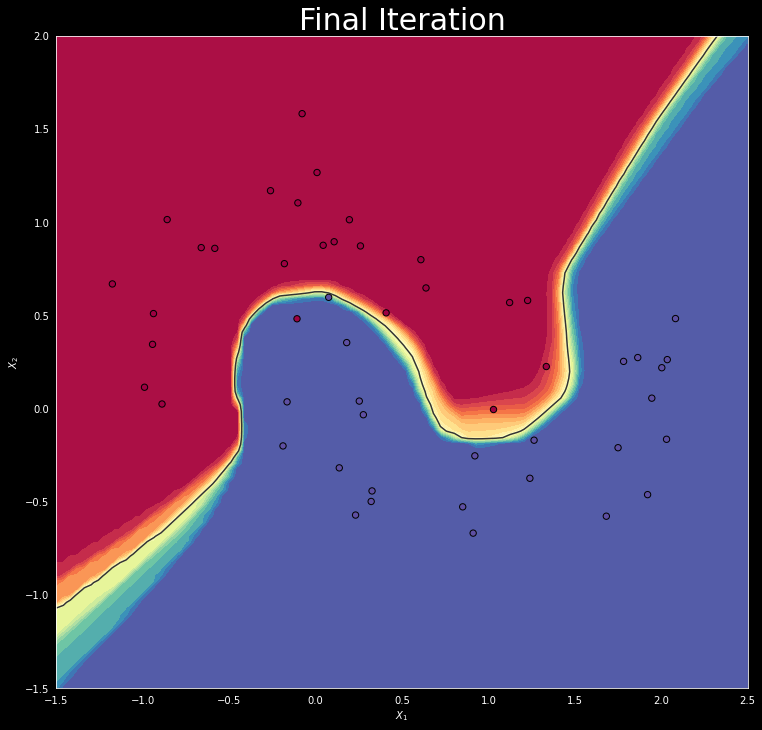

In [ ]:
act = model.forward_prop(np.transpose(grid_2d))
prediction_probs_np = act[-1]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "Final Iteration", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)